In [83]:
import pandas as pd
import pingouin as pg
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau
from read_data import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Main text analyses

In [23]:
allsubjdata = pd.read_csv('data/allsubjdata.csv')

In [24]:
exclude_subjs = subject_exclusion(allsubjdata)
allsubjdata_noexcl = allsubjdata.copy()
allsubjdata = allsubjdata[~allsubjdata.subject.isin(exclude_subjs)]
print(f'Excluded {len(exclude_subjs)} out of {allsubjdata_noexcl.subject.nunique()} subjects.')
print('Final sample size:', allsubjdata.subject.nunique())

Excluded 119 out of 271 subjects.
Final sample size: 152


In [58]:
# Get mean accuracy per participant, for each experiment
allsubjdata = compute_dprimes(allsubjdata) # used in supp. analysis
p75data = allsubjdata[allsubjdata['p_exp']==0.75]
p50data = allsubjdata[allsubjdata['p_exp']==0.5]
p25data = allsubjdata[allsubjdata['p_exp']==0.25]
p75means = p75data.groupby(['subject', 'expected']).mean().reset_index()
p50means = p50data.groupby(['subject', 'expected']).mean().reset_index()
p25means = p25data.groupby(['subject', 'expected']).mean().reset_index()
allmeans = allsubjdata.groupby(['subject', 'expected', 'p_exp']).mean().reset_index()

### Experiment 1

In [31]:
# Mean accuracy for congruent and incongruent trials
p75means.groupby(['expected'])[['hit']].agg(['mean', 'sem'])

hit          
              mean       sem
expected                    
0.0       0.649214  0.011620
1.0       0.714852  0.007569

In [28]:
pg.ttest(p75means[p75means['expected']==1].hit, 
         p75means[p75means['expected']==0].hit, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,5.867221,49,two-sided,3.746083e-07,"[0.04, 0.09]",0.946649,4.113e+04,1.0


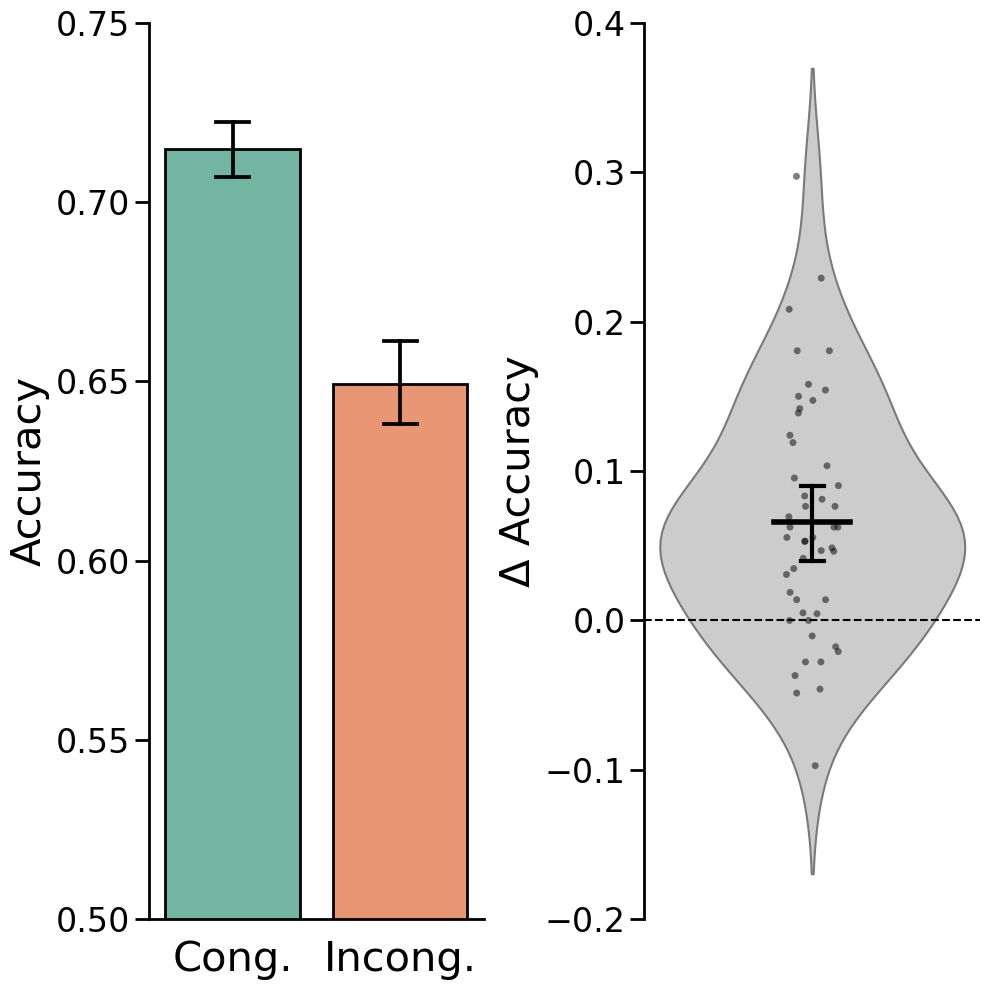

In [30]:
# Plot accuracy for congruent and incongruent trials
make_pretty_plot(p75means, measure='hit')

### Experiment 2

In [33]:
# Mean accuracy for congruent and incongruent trials
p50means.groupby(['expected'])[['hit']].agg(['mean', 'sem'])

hit          
              mean       sem
expected                    
0.0       0.678791  0.009089
1.0       0.704249  0.006872

In [34]:
pg.ttest(p50means[p50means['expected']==1].hit, 
         p50means[p50means['expected']==0].hit, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.56107,49,two-sided,0.013565,"[0.01, 0.05]",0.446877,2.894,0.872321


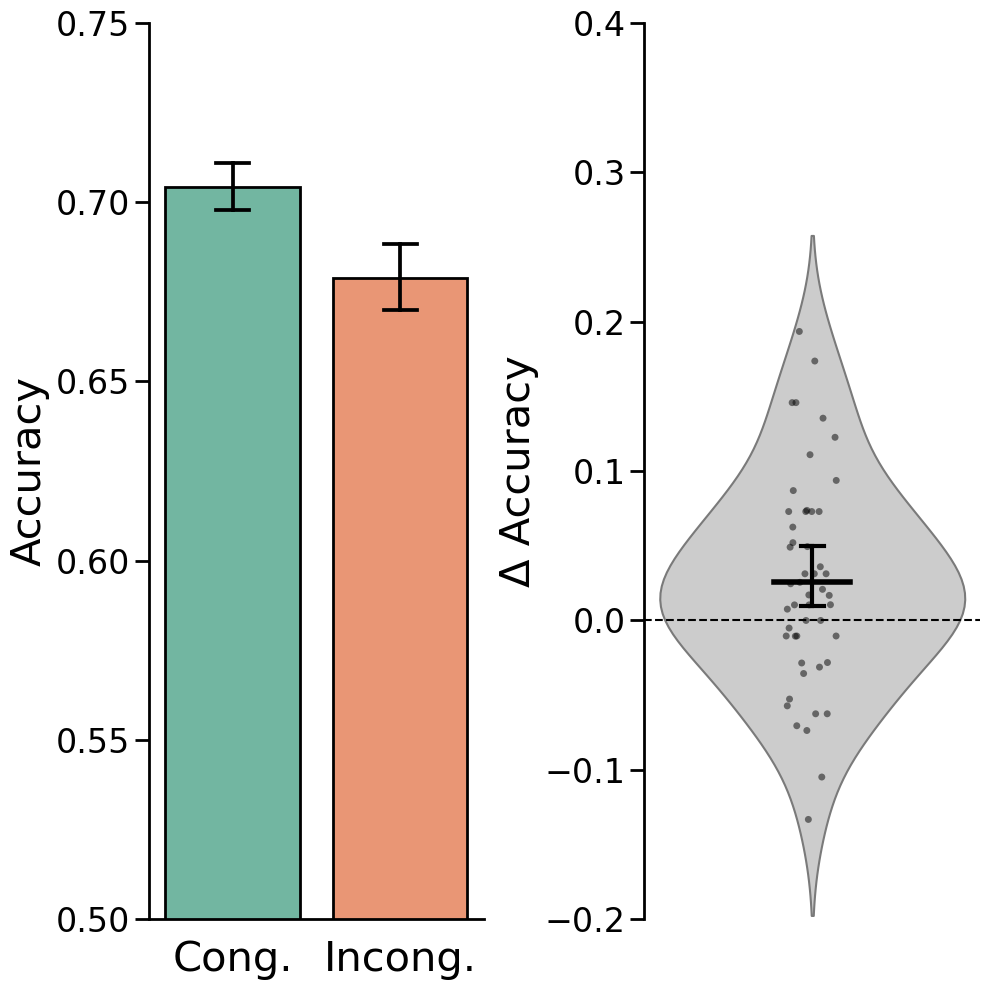

In [35]:
# Plot accuracy for congruent and incongruent trials
make_pretty_plot(p50means, measure='hit')

### Experiment 3

In [36]:
# Mean accuracy for congruent and incongruent trials
p25means.groupby(['expected'])[['hit']].agg(['mean', 'sem'])

hit          
              mean       sem
expected                    
0.0       0.676988  0.007286
1.0       0.707034  0.010151

In [37]:
pg.ttest(p25means[p25means['expected']==1].hit, 
         p25means[p25means['expected']==0].hit, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.502783,51,two-sided,0.000967,"[0.01, 0.05]",0.471576,28.968,0.915576


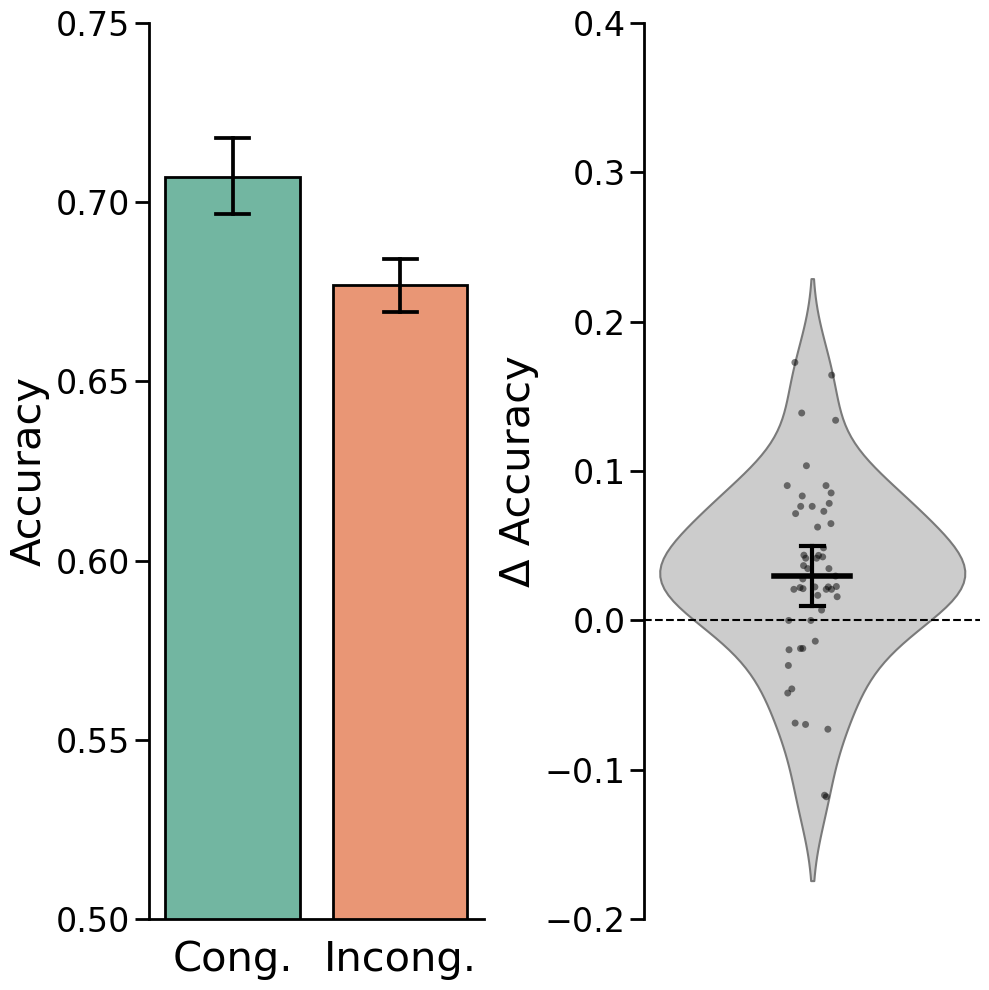

In [38]:
# Plot accuracy for congruent and incongruent trials
make_pretty_plot(p25means, measure='hit')

### Probability-congruency interaction (across experiments)

In [39]:
aov = pg.mixed_anova(dv='hit', within='expected',
                             between='p_exp',
                             subject='subject', 
                             data=allmeans)
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
p_exp        0.006      2    149  0.003   0.571    0.566  0.008  nan
expected     0.123      1    149  0.123  49.313    0.000  0.249    1.000
Interaction  0.024      2    149  0.012   4.866    0.009  0.061  nan



In [40]:
allhitdiffs = []
allpexp = []
for pe in allmeans.p_exp.unique():
    thesediffs = list(allmeans[(allmeans['p_exp']==pe)&(allmeans['expected']==1)].hit.values - \
        allmeans[(allmeans['p_exp']==pe)&(allmeans['expected']==0)].hit.values)
    allhitdiffs.extend(thesediffs)
    allpexp.extend([pe] * len(thesediffs))
allhitdiffs = pd.DataFrame(list(zip(allpexp, allhitdiffs)), columns =['p_exp', 'diff'])

In [43]:
# Pairwise tests
pairwisepvals = []
for pair in [[0.75, 0.5], [0.75, 0.25], [0.5, 0.25]]:
    tstats = pg.ttest(allhitdiffs[allhitdiffs['p_exp']==pair[0]]['diff'], allhitdiffs[allhitdiffs['p_exp']==pair[1]]['diff'])
    print(f"{pair[0]} vs. {pair[1]}")
    print('===================')
    pg.print_table(tstats)
    pairwisepvals.append(tstats['p-val'])
    print('-------------------')

0.75 vs. 0.5
    T    dof  tail         p-val  CI95%          cohen-d    BF10    power
-----  -----  ---------  -------  -----------  ---------  ------  -------
2.685     98  two-sided    0.009  [0.01 0.07]      0.537   4.868    0.758

-------------------
0.75 vs. 0.25
    T     dof  tail         p-val  CI95%          cohen-d    BF10    power
-----  ------  ---------  -------  -----------  ---------  ------  -------
2.525  92.750  two-sided    0.013  [0.01 0.06]      0.502   3.401    0.710

-------------------
0.5 vs. 0.25
     T     dof  tail         p-val  CI95%            cohen-d    BF10    power
------  ------  ---------  -------  -------------  ---------  ------  -------
-0.349  97.306  two-sided    0.728  [-0.03  0.02]      0.069   0.221    0.064

-------------------


In [44]:
# Correct for multiple comparisons
pg.multicomp(pairwisepvals, method='bonf')

(array([ True,  True, False]), array([0.02556637, 0.03983202, 1.        ]))

## Supplemental analyses

### Results without exclusions

In [45]:
p75means_noexcl = allsubjdata_noexcl[allsubjdata_noexcl['p_exp']==0.75].groupby(
    ['subject', 'expected']).mean().reset_index()
p50means_noexcl = allsubjdata_noexcl[allsubjdata_noexcl['p_exp']==0.5].groupby(
    ['subject', 'expected']).mean().reset_index()
p25means_noexcl = allsubjdata_noexcl[allsubjdata_noexcl['p_exp']==0.25].groupby(
    ['subject', 'expected']).mean().reset_index()
allmeans_noexcl = allsubjdata_noexcl.groupby([
    'subject', 'expected', 'p_exp']).mean().reset_index()

Experiment 1

In [46]:
p75means_noexcl.groupby(['expected'])[['hit']].agg(['mean', 'sem'])

hit          
              mean       sem
expected                    
0.0       0.595276  0.011819
1.0       0.636932  0.012666

In [47]:
pg.ttest(p75means_noexcl[p75means_noexcl['expected']==1].hit, 
         p75means_noexcl[p75means_noexcl['expected']==0].hit, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.084505,79,two-sided,0.000105,"[0.02, 0.06]",0.380194,189.71,0.91909


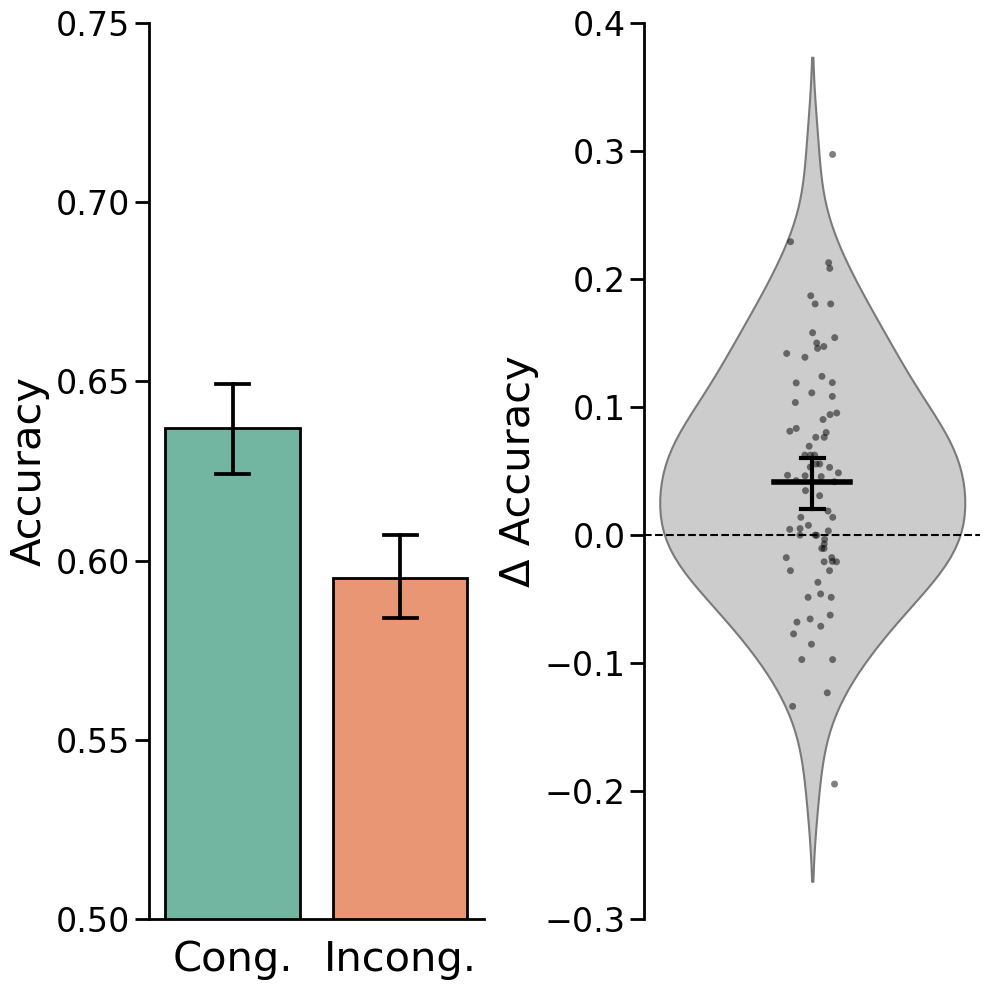

In [50]:
make_pretty_plot(p75means_noexcl, measure='hit', excl=False)

Experiment 2

In [48]:
p50means_noexcl.groupby(['expected'])[['hit']].agg(['mean', 'sem'])

hit          
              mean       sem
expected                    
0.0       0.610973  0.011106
1.0       0.632730  0.011385

In [52]:
pg.ttest(p50means_noexcl[p50means_noexcl['expected']==1].hit, 
         p50means_noexcl[p50means_noexcl['expected']==0].hit, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.911263,82,two-sided,0.004634,"[0.01, 0.04]",0.212356,6.045,0.480918


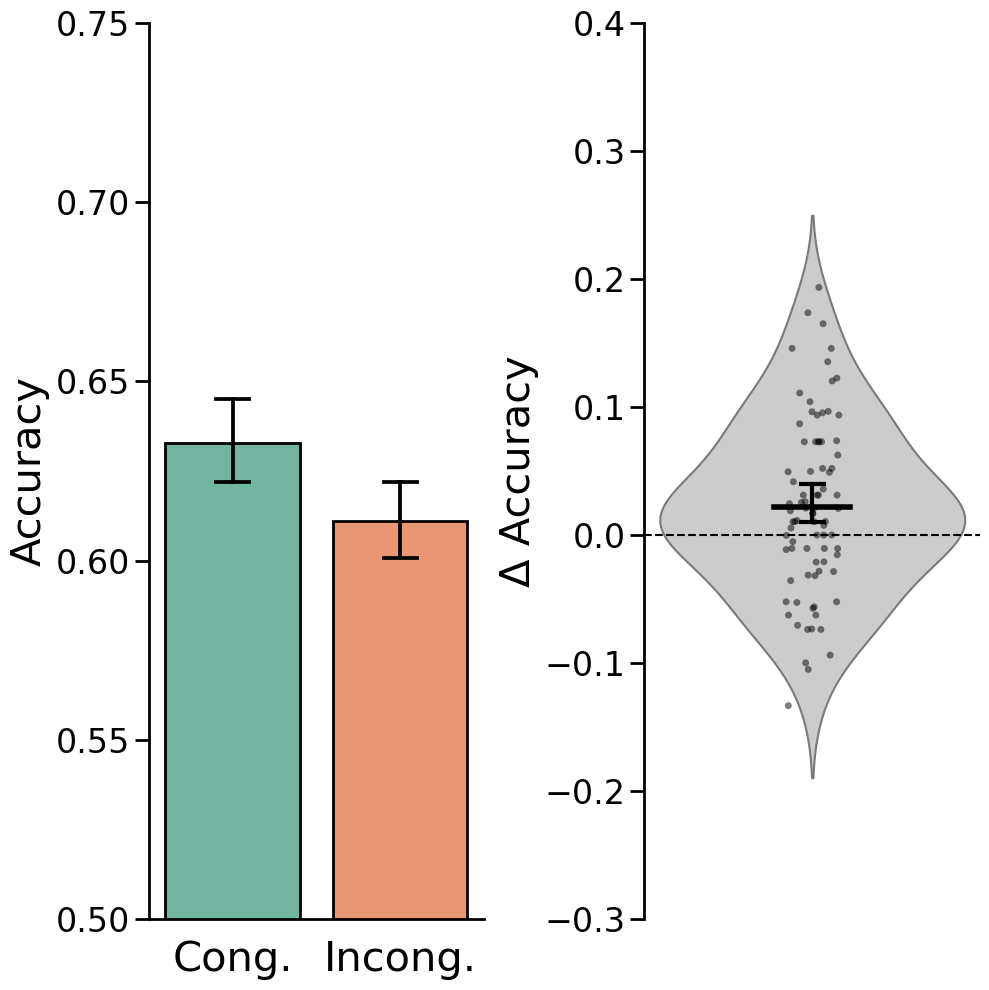

In [53]:
make_pretty_plot(p50means_noexcl, measure='hit', excl=False)

Experiment 3

In [54]:
p25means_noexcl.groupby(['expected'])[['hit']].agg(['mean', 'sem'])

hit          
              mean       sem
expected                    
0.0       0.583932  0.009671
1.0       0.610524  0.011283

In [55]:
pg.ttest(p25means_noexcl[p25means_noexcl['expected']==1].hit, 
         p25means_noexcl[p25means_noexcl['expected']==0].hit, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.764513,107,two-sided,0.000273,"[0.01, 0.04]",0.243525,70.747,0.708174


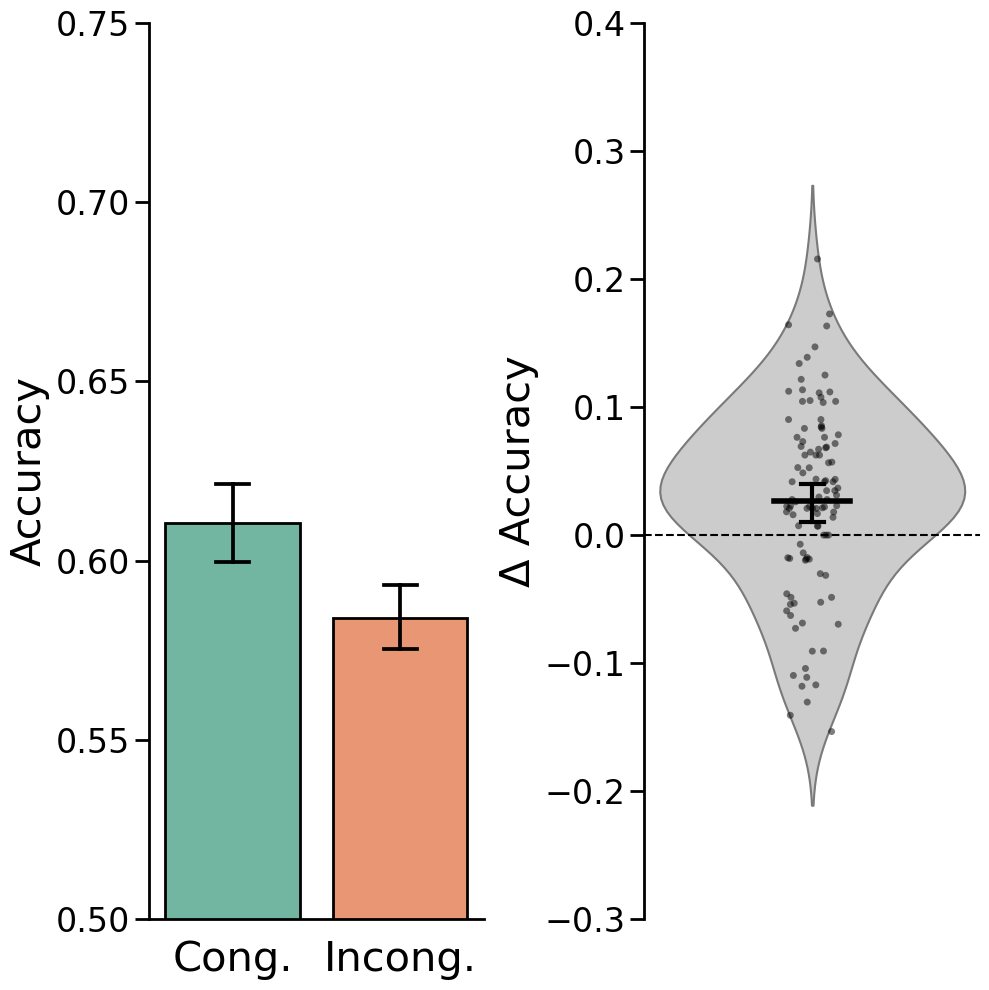

In [56]:
make_pretty_plot(p25means_noexcl, measure='hit', excl=False)

### Sensitivity and bias

Experiment 1

In [59]:
# Mean accuracy for congruent and incongruent trials
p75means.groupby(['expected'])[['dprime', 'criterion']].agg(['mean', 'sem'])

dprime           criterion          
              mean       sem      mean       sem
expected                                        
0.0       0.484739  0.049828  0.565118  0.033726
1.0       0.747401  0.031528  0.821292  0.017333

In [60]:
pg.ttest(p75means[p75means['expected']==1].dprime, 
         p75means[p75means['expected']==0].dprime, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.528704,49,two-sided,0.000038,"[0.15, 0.38]",0.890907,556.077,1.0


In [61]:
pg.ttest(p75means[p75means['expected']==1].criterion, 
         p75means[p75means['expected']==0].criterion, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,6.6326,49,two-sided,2.460869e-08,"[0.18, 0.33]",1.351145,5.36e+05,1.0


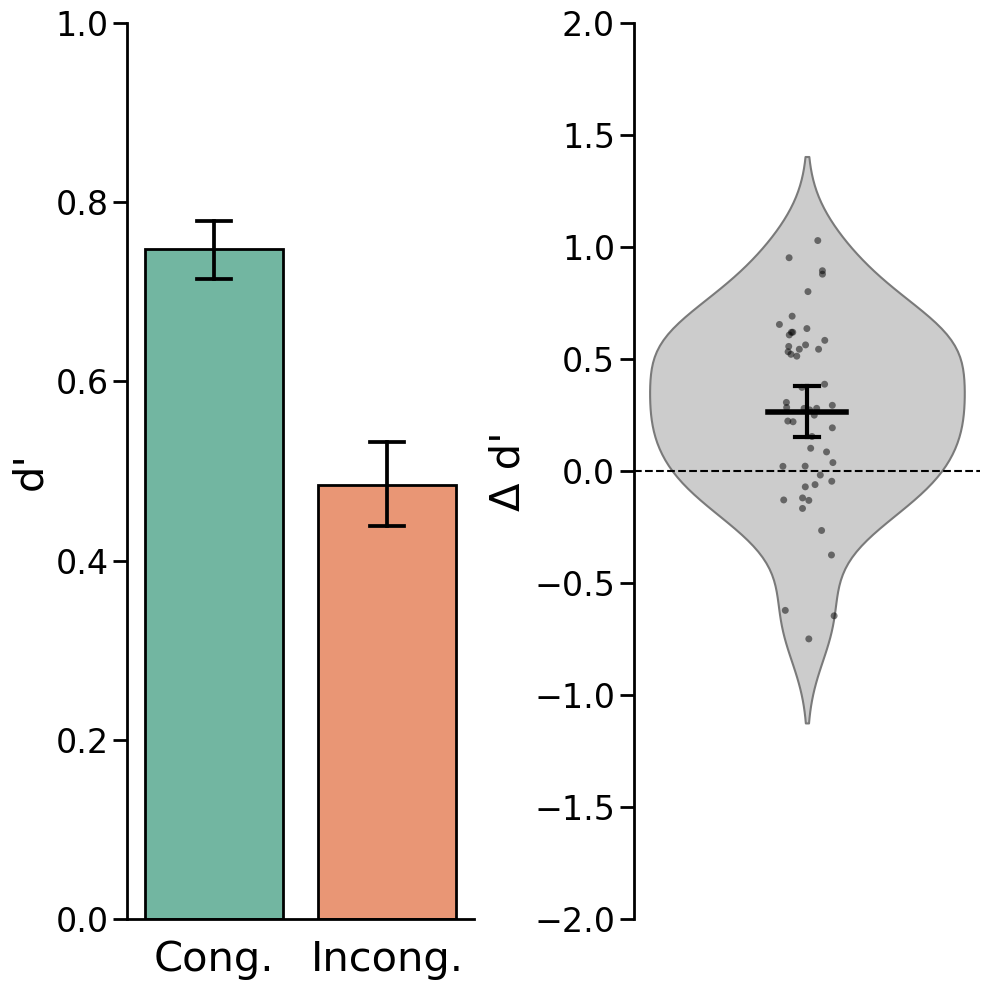

In [62]:
make_pretty_plot(p75means, measure='dprime')

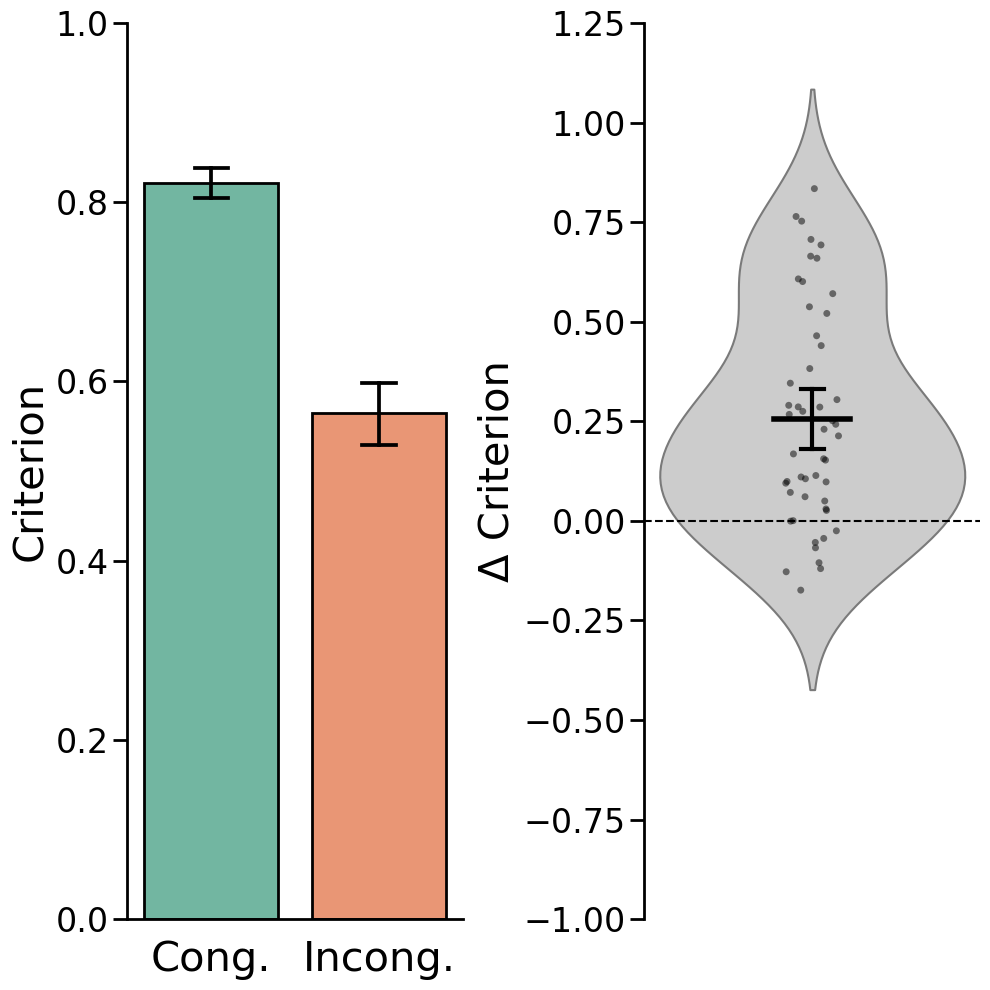

In [63]:
make_pretty_plot(p75means, measure='criterion')

Experiment 2

In [64]:
# Mean accuracy for congruent and incongruent trials
p50means.groupby(['expected'])[['dprime', 'criterion']].agg(['mean', 'sem'])

dprime           criterion          
              mean       sem      mean       sem
expected                                        
0.0       0.594017  0.036687  0.707926  0.023401
1.0       0.750409  0.045331  0.816146  0.024761

In [65]:
pg.ttest(p50means[p50means['expected']==1].dprime, 
         p50means[p50means['expected']==0].dprime, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.528704,49,two-sided,0.000038,"[0.15, 0.38]",0.890907,556.077,1.0


In [66]:
pg.ttest(p50means[p50means['expected']==1].criterion, 
         p50means[p50means['expected']==0].criterion, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,6.6326,49,two-sided,2.460869e-08,"[0.18, 0.33]",1.351145,5.36e+05,1.0


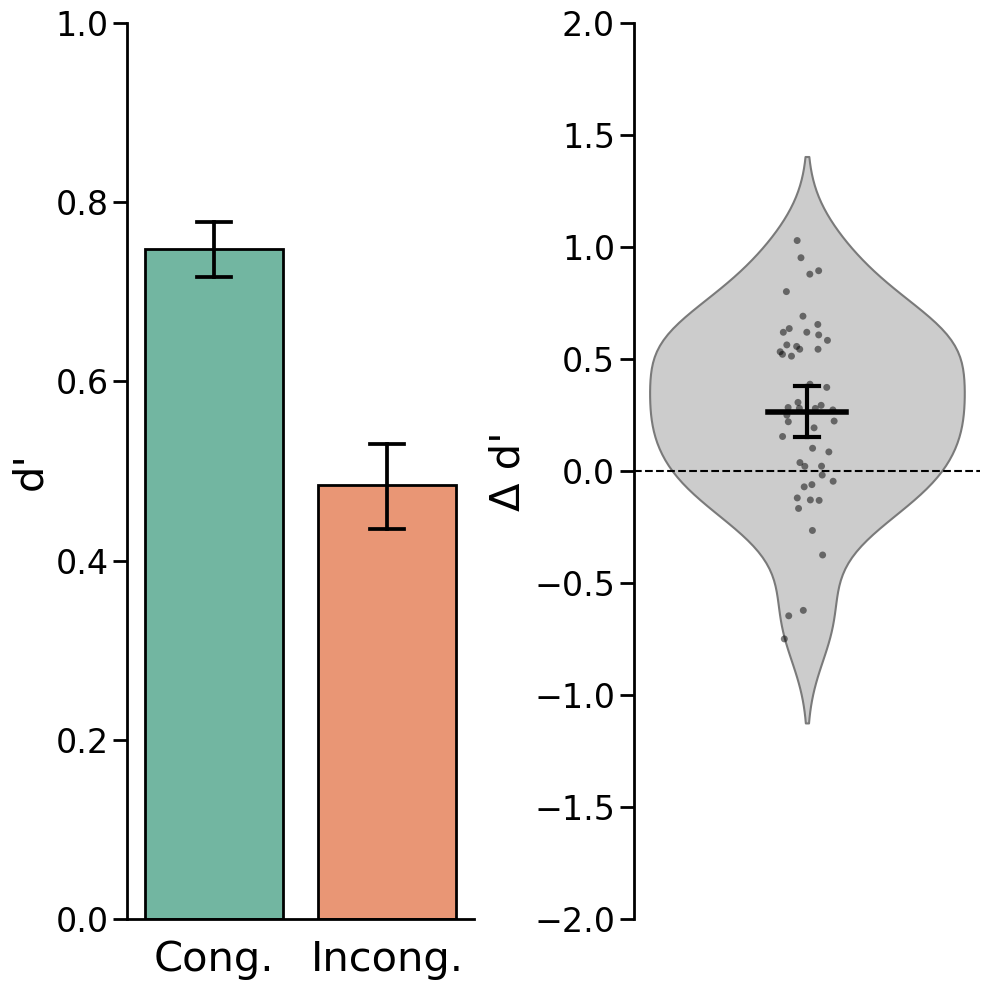

In [67]:
make_pretty_plot(p50means, measure='dprime')

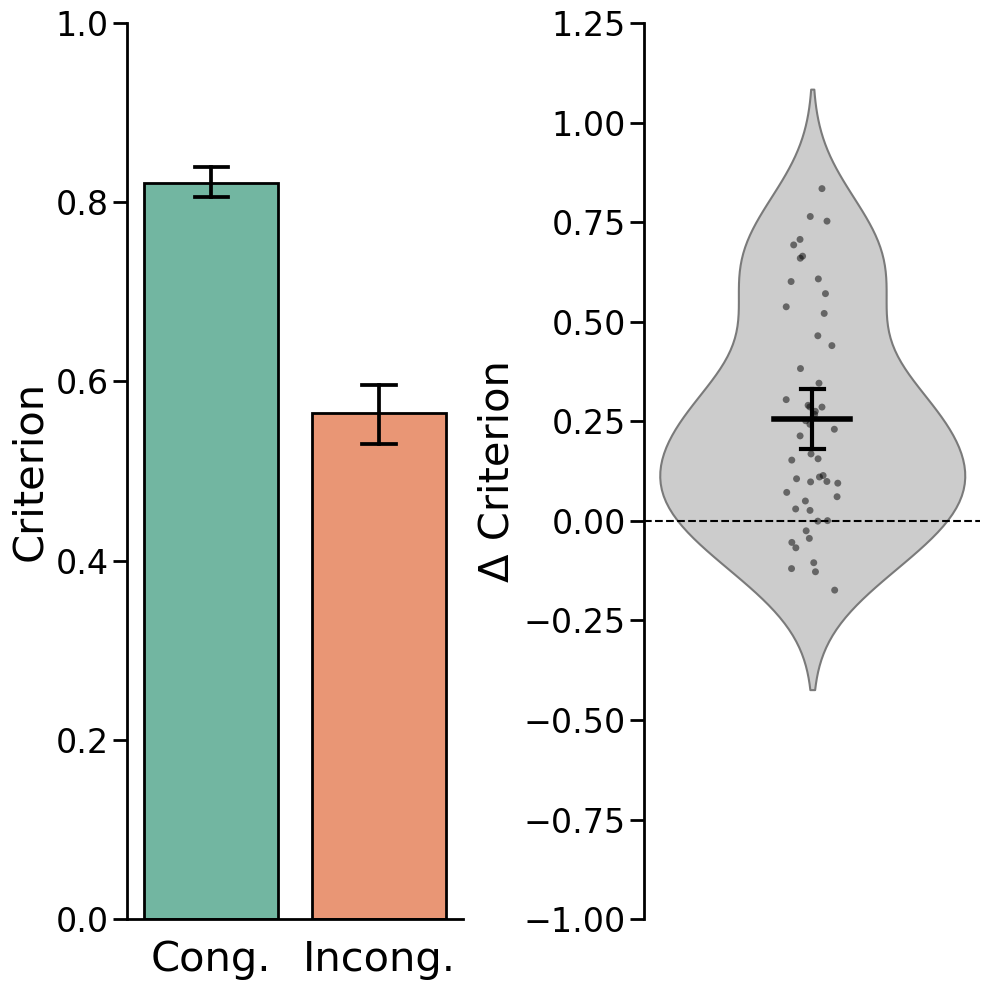

In [68]:
make_pretty_plot(p50means, measure='criterion')

Experiment 3

In [69]:
# Mean accuracy for congruent and incongruent trials
p25means.groupby(['expected'])[['dprime', 'criterion']].agg(['mean', 'sem'])

dprime           criterion          
              mean       sem      mean       sem
expected                                        
0.0       0.593328  0.034323  0.730321  0.020292
1.0       0.779400  0.052984  0.836958  0.024460

In [70]:
pg.ttest(p25means[p25means['expected']==1].dprime, 
         p25means[p25means['expected']==0].dprime, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.921716,51,two-sided,0.000263,"[0.09, 0.28]",0.578048,93.741,0.983361


In [71]:
pg.ttest(p25means[p25means['expected']==1].criterion, 
         p25means[p25means['expected']==0].criterion, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.595209,51,two-sided,0.00073,"[0.05, 0.17]",0.658038,37.281,0.996472


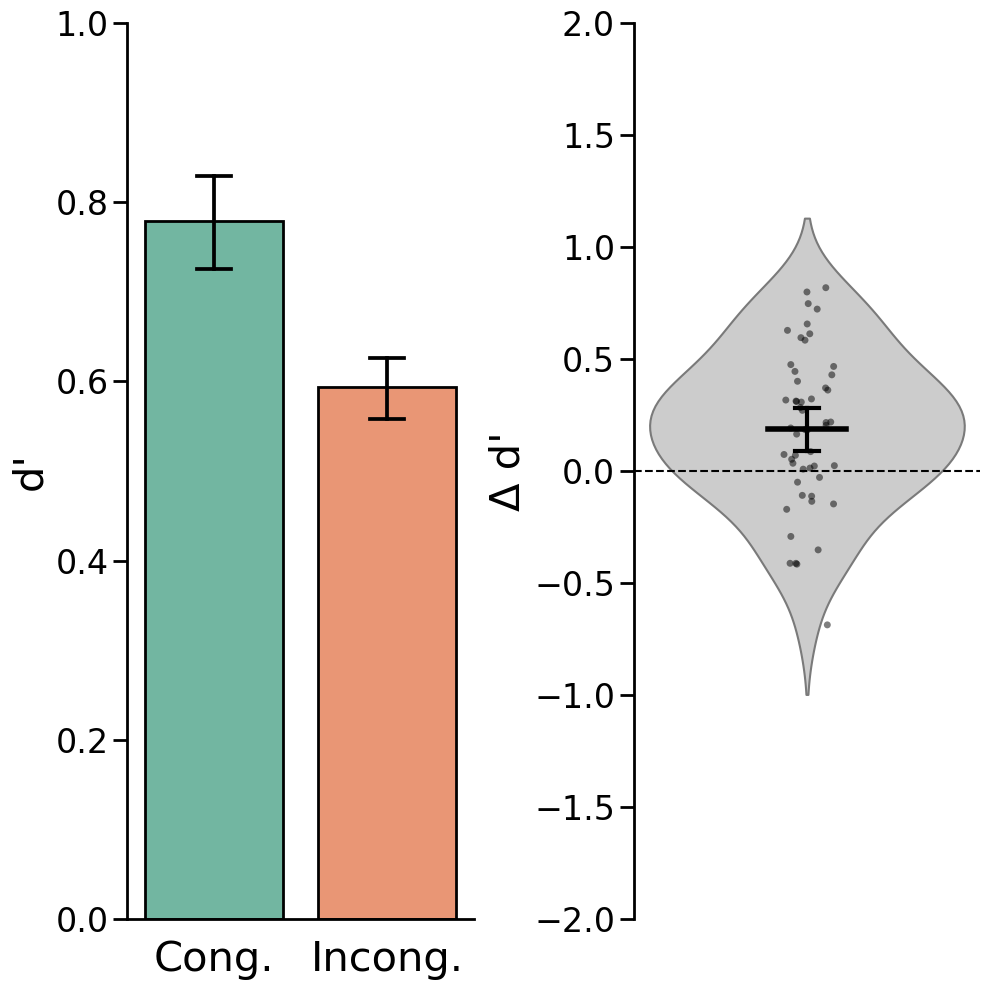

In [72]:
make_pretty_plot(p25means, measure='dprime')

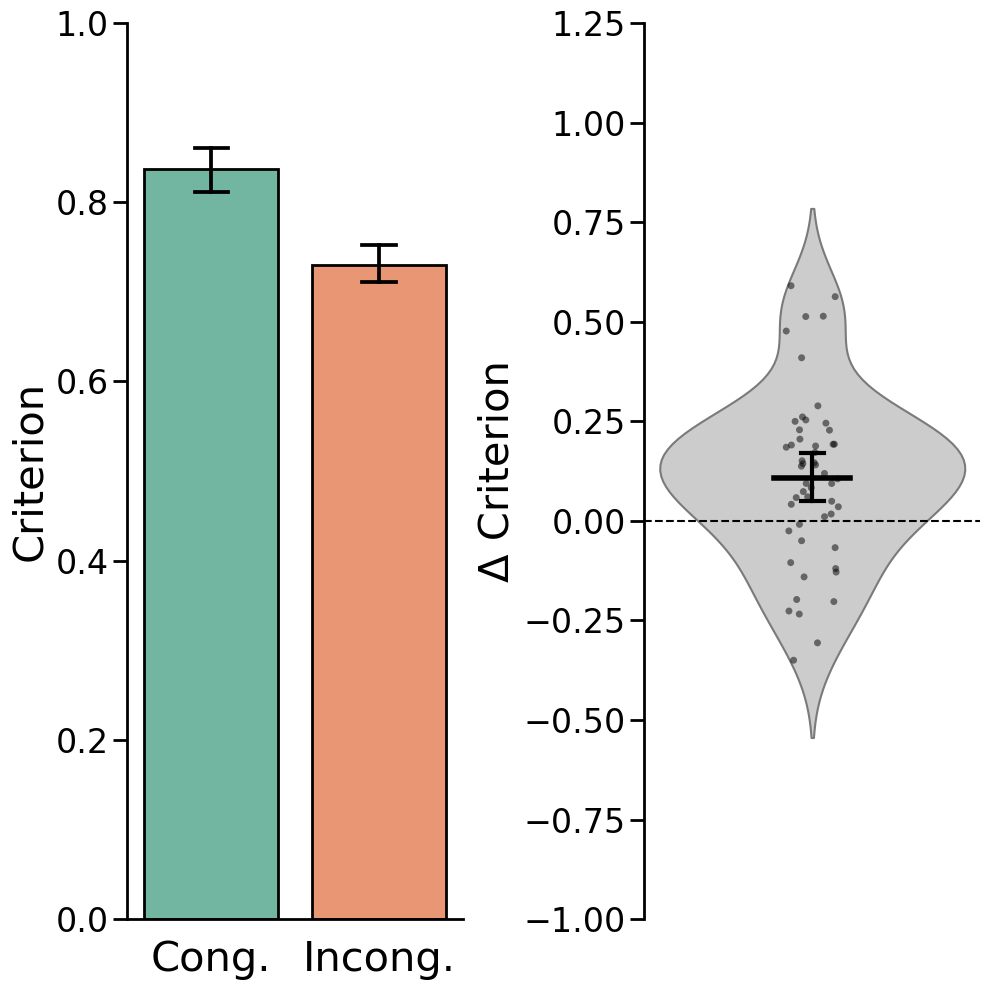

In [73]:
make_pretty_plot(p25means, measure='criterion')

### Aligned vs. Misaligned

In [74]:
almisaldata = allsubjdata.copy()
almisaldata['aligned']=allsubjdata['initview'].isin([0, 180])
for al in almisaldata.aligned.unique():
    almisaldata[almisaldata['aligned']==al] = compute_dprimes(almisaldata[almisaldata['aligned']==al])
almisalmeans = almisaldata.groupby(['p_exp', 'aligned', 'expected', 'subject']).mean().reset_index()

In [75]:
almisalmeans.groupby(['aligned', 'expected']).hit.mean()

aligned  expected
False    0.0         0.658805
         1.0         0.688426
True     0.0         0.687778
         1.0         0.749311
Name: hit, dtype: float64

In [76]:
aov = pg.rm_anova(almisalmeans, dv='hit', within=['aligned', 'expected'], subject='subject')
pg.print_table(aov)


ANOVA SUMMARY

Source                 SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr    np2    eps
------------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
aligned             0.307        1      151  0.307  55.289    0.000        0.000  0.268  1.000
expected            0.316        1      151  0.316  48.556    0.000        0.000  0.243  1.000
aligned * expected  0.039        1      151  0.039   5.182    0.024        0.024  0.033  1.000



In [77]:
pg.ttest(almisalmeans[(almisalmeans['aligned']==True)&(almisalmeans['expected']==1)]['hit'],
         almisalmeans[(almisalmeans['aligned']==True)&(almisalmeans['expected']==0)]['hit'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,5.334743,151,two-sided,3.435176e-07,"[0.04, 0.08]",0.594231,3.33e+04,1.0


In [78]:
pg.ttest(almisalmeans[(almisalmeans['aligned']==False)&(almisalmeans['expected']==1)]['hit'],
         almisalmeans[(almisalmeans['aligned']==False)&(almisalmeans['expected']==0)]['hit'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.156551,151,two-sided,0.000054,"[0.02, 0.04]",0.414768,279.637,0.999098


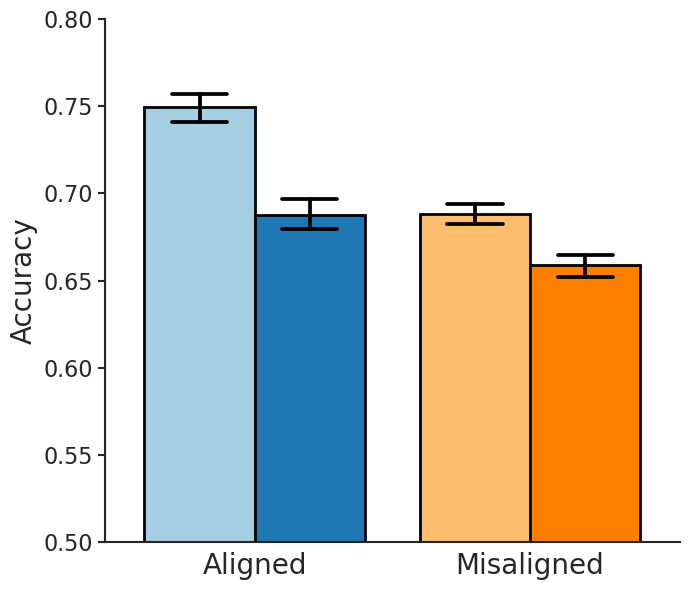

In [80]:
make_align_plot_together(almisalmeans, measure='hit')

### Final survey

In [100]:
allsurveys = get_surveys(allsubjdata)

In [101]:
allsurveys.subject.nunique()

152

In [102]:
allsurveys.groupby(['p_exp'])[['sequence_attention', 
                               'object_expect',
                               'percent_expected']].agg(['mean', 'sem'])

sequence_attention           object_expect           percent_expected  \
                    mean       sem          mean       sem             mean   
p_exp                                                                         
0.25                4.00  0.229762      3.884615  0.170736        50.846154   
0.50                3.90  0.219926      4.020000  0.196894        54.800000   
0.75                4.34  0.207236      3.900000  0.190059        60.480000   

                 
            sem  
p_exp            
0.25   2.276741  
0.50   2.481441  
0.75   2.459341

In [103]:
aov = pg.welch_anova(dv='sequence_attention', between='p_exp', data=allsurveys)

pg.print_table(aov)


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
p_exp           2   99.246  1.169    0.315  0.014



In [104]:
aov = pg.welch_anova(dv='object_expect', between='p_exp', data=allsurveys)

pg.print_table(aov)


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
p_exp           2   98.694  0.151    0.860  0.002



In [105]:
aov = pg.welch_anova(dv='percent_expected', between='p_exp', data=allsurveys)

pg.print_table(aov)


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
p_exp           2   98.998  4.117    0.019  0.052



In [106]:
print('==================')
print('Overall')
print('------------------')
accdiffs = allmeans[allmeans['expected']==1].hit.values - \
           allmeans[allmeans['expected']==0].hit.values
critdiffs = allmeans[allmeans['expected']==1].criterion.values - \
            allmeans[allmeans['expected']==0].criterion.values
dprdiffs = allmeans[allmeans['expected']==1].dprime.values - \
           allmeans[allmeans['expected']==0].dprime.values
print('Accuracy-sequence attention correlation:')
stats = pg.corr(allsurveys.sequence_attention, accdiffs, method='pearson')
print('r =', stats['r'][0], '- p =', stats['p-val'][0], '- BF01 =', 1/float(stats['BF10'][0]), '\n')

print('Accuracy-object prediction correlation:')
stats = pg.corr(allsurveys.object_expect, accdiffs, method='pearson')
print('r =', stats['r'][0], '- p =', stats['p-val'][0], '- BF01 =', 1/float(stats['BF10'][0]), '\n')

print('Accuracy-probability estimate correlation:')
stats = pg.corr(allsurveys.percent_expected, accdiffs, method='pearson')
print('r =', stats['r'][0], '- p =', stats['p-val'][0], '- BF01 =', 1/float(stats['BF10'][0]), '\n')

for pe in [0.75, 0.5, 0.25]:
    print('==================')
    print('P(Exp) =', pe)
    print('------------------')
    thispexp = allmeans[allmeans['p_exp']==pe]
    critdiffs = thispexp[thispexp['expected']==1].criterion.values - \
                thispexp[thispexp['expected']==0].criterion.values
    dprdiffs = thispexp[thispexp['expected']==1].dprime.values - \
               thispexp[thispexp['expected']==0].dprime.values
    accdiffs = thispexp[thispexp['expected']==1].hit.values - \
               thispexp[thispexp['expected']==0].hit.values
    print('Accuracy-sequence attention correlation:')
    stats = pg.corr(allsurveys[allsurveys['p_exp']==pe].sequence_attention, accdiffs, method='pearson')
    print('r =', stats['r'][0], '- p =', stats['p-val'][0], '- BF01 =', 1/float(stats['BF10'][0]), '\n')
    
    print('-------------------------------')
    print('Accuracy-object prediction correlation:')
    stats = pg.corr(allsurveys[allsurveys['p_exp']==pe].object_expect, accdiffs, method='pearson')
    print('r =', stats['r'][0], '- p =', stats['p-val'][0], '- BF01 =', 1/float(stats['BF10'][0]), '\n')
    
    print('-------------------------------')
    print('Accuracy-probability estimate correlation:')
    stats = pg.corr(allsurveys[allsurveys['p_exp']==pe].percent_expected, accdiffs, method='pearson')
    print('r =', stats['r'][0], '- p =', stats['p-val'][0], '- BF01 =', 1/float(stats['BF10'][0]), '\n')

Overall
------------------
Accuracy-sequence attention correlation:
r = 0.06874750419616933 - p = 0.4000254927972161 - BF01 = 6.944444444444445 

Accuracy-object prediction correlation:
r = 0.00968837192506096 - p = 0.9057007922131672 - BF01 = 9.803921568627452 

Accuracy-probability estimate correlation:
r = -0.0196025159289427 - p = 0.8105596930487207 - BF01 = 9.615384615384615 

P(Exp) = 0.75
------------------
Accuracy-sequence attention correlation:
r = 0.18850322050439572 - p = 0.1898596304643574 - BF01 = 2.4570024570024573 

-------------------------------
Accuracy-object prediction correlation:
r = 0.10269608280361799 - p = 0.4779002691380043 - BF01 = 4.444444444444445 

-------------------------------
Accuracy-probability estimate correlation:
r = -0.13983718103720721 - p = 0.3327655220669713 - BF01 = 3.597122302158273 

P(Exp) = 0.5
------------------
Accuracy-sequence attention correlation:
r = -0.0066443052867197865 - p = 0.9634740517648098 - BF01 = 5.649717514124294 

----